In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import transforms3d

In [2]:
def inverse_kinematics(x: float, y: float, z: float, a1: float, a2: float):
    y_prime = -math.sqrt((z)**2 + y**2)
    thetaz = math.atan2(abs(y), z)

    c2 = (x**2 + y_prime**2 - a1**2 - a2**2) / (2 * a1 * a2)
    s2 = math.sqrt(abs(1 - c2**2))
    theta2 = math.atan2(s2, c2)

    c1 = (x * (a1 + (a2 * c2)) + y_prime * (a2 * s2)) / (x**2 + y_prime**2)
    s1 = (y_prime * (a1 + (a2 * c2)) - x * (a2 * s2)) / (x**2 + y_prime**2)
    theta1 = math.atan2(s1, c1)

    theta_shoulder = -theta1
    theta_elbow = theta_shoulder - theta2
    theta_hip = thetaz

    return math.degrees(theta_shoulder), math.degrees(theta_elbow), math.degrees(theta_hip)

In [3]:
# 設定機器狗的參數
body_length = 20  # 前後腿間距 (X 軸)
body_width = 15   # 左右腿間距 (Z 軸)
leg_upper_length = 10  # 大腿長度 (Y 軸)
leg_lower_length = 10  # 小腿長度 (Y 軸)
stand_height = 15  # 站立高度 (肩部到地面)

# 機器狗的肩部位置 (X, Z, Y)
shoulder_positions = np.array([
    [-body_length / 2, -body_length / 2, body_length / 2, body_length / 2],
    [-body_width / 2, body_width / 2, -body_width / 2, body_width / 2],
    [0, 0, 0, 0],
])

# 計算膝部和腳端位置（使用逆向運動學）
knee_positions = np.zeros_like(shoulder_positions)
foot_positions = np.zeros_like(shoulder_positions)

for i in range(4):
    x, z, y = shoulder_positions[:,i]
    theta_shoulder, theta_elbow, theta_hip = inverse_kinematics(0, -stand_height, 0, leg_upper_length, leg_lower_length)
    print("theta: ", theta_shoulder, theta_elbow, theta_hip)

    knee_x = x + leg_upper_length * math.cos(math.radians(theta_shoulder))
    knee_y = y - leg_upper_length * math.sin(math.radians(theta_shoulder))
    knee_z = z + leg_upper_length * math.sin(math.radians(90 - theta_hip))
    foot_x = knee_x + leg_lower_length * math.cos(math.radians(theta_elbow))
    foot_y = knee_y - leg_lower_length * math.sin(math.radians(theta_elbow))
    foot_z = knee_z + leg_lower_length * math.sin(math.radians(90 - theta_hip))
    print("x: ", x, "knee_x: ", knee_x, "foot_x: ", foot_x)
    print("y: ", y, "knee_y: ", knee_y, "foot_y: ", foot_y)
    print("z: ", z, "knee_z: ", knee_z, "foot_z: ", foot_z)
    knee_positions[:,i] = [knee_x, knee_z, knee_y]
    
    foot_positions[:,i] = [foot_x, foot_z, foot_y]

theta:  131.40962210927086 48.59037789072913 90.0
x:  -10.0 knee_x:  -16.614378277661476 foot_x:  -9.999999999999998
y:  0.0 knee_y:  -7.500000000000001 foot_y:  -15.0
z:  -7.5 knee_z:  -7.5 foot_z:  -7.5
theta:  131.40962210927086 48.59037789072913 90.0
x:  -10.0 knee_x:  -16.614378277661476 foot_x:  -9.999999999999998
y:  0.0 knee_y:  -7.500000000000001 foot_y:  -15.0
z:  7.5 knee_z:  7.5 foot_z:  7.5
theta:  131.40962210927086 48.59037789072913 90.0
x:  10.0 knee_x:  3.3856217223385245 foot_x:  10.000000000000004
y:  0.0 knee_y:  -7.500000000000001 foot_y:  -15.0
z:  -7.5 knee_z:  -7.5 foot_z:  -7.5
theta:  131.40962210927086 48.59037789072913 90.0
x:  10.0 knee_x:  3.3856217223385245 foot_x:  10.000000000000004
y:  0.0 knee_y:  -7.500000000000001 foot_y:  -15.0
z:  7.5 knee_z:  7.5 foot_z:  7.5


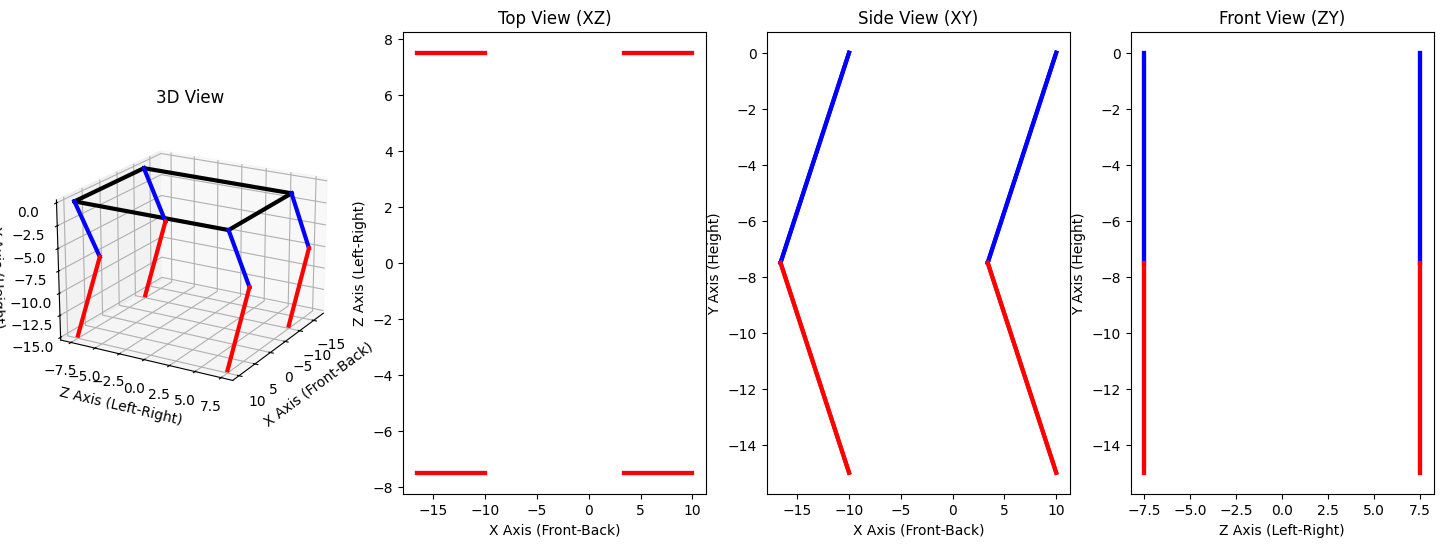

In [4]:
# 繪製 3D 及 3 個 2D 視角的機器狗模型
fig = plt.figure(figsize=(18, 6))

# 3D 視圖
ax3d = fig.add_subplot(141, projection='3d')
ax3d.set_title("3D View")
ax3d.set_xlabel("X Axis (Front-Back)")
ax3d.set_ylabel("Z Axis (Left-Right)")
ax3d.set_zlabel("Y Axis (Height)")
ax3d.view_init(elev=20, azim=30)

# XZ 平面 (正視圖)
ax_xz = fig.add_subplot(142)
ax_xz.set_title("Top View (XZ)")
ax_xz.set_xlabel("X Axis (Front-Back)")
ax_xz.set_ylabel("Z Axis (Left-Right)")

# XY 平面 (側視圖)
ax_xy = fig.add_subplot(143)
ax_xy.set_title("Side View (XY)")
ax_xy.set_xlabel("X Axis (Front-Back)")
ax_xy.set_ylabel("Y Axis (Height)")

# ZY 平面 (俯視圖)
ax_zy = fig.add_subplot(144)
ax_zy.set_title("Front View (ZY)")
ax_zy.set_xlabel("Z Axis (Left-Right)")
ax_zy.set_ylabel("Y Axis (Height)")

# 繪製 3D 身體
body_lines = [
    (shoulder_positions[:, 0], shoulder_positions[:, 1]),
    (shoulder_positions[:, 2], shoulder_positions[:, 3]),
    (shoulder_positions[:, 0], shoulder_positions[:, 2]),
    (shoulder_positions[:, 1], shoulder_positions[:, 3]),
]

for line in body_lines:
    ax3d.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], [line[0][2], line[1][2]], 'k-', lw=3)

# 繪製 3D 腿部
for i in range(4):
    ax3d.plot(
        [shoulder_positions[0, i], knee_positions[0, i]],
        [shoulder_positions[1, i], knee_positions[1, i]],
        [shoulder_positions[2, i], knee_positions[2, i]],
        'b-', lw=3)  # 大腿

    ax3d.plot(
        [knee_positions[0, i], foot_positions[0, i]],
        [knee_positions[1, i], foot_positions[1, i]],
        [knee_positions[2, i], foot_positions[2, i]],
        'r-', lw=3)  # 小腿

# 繪製 XZ 平面
for i in range(4):
    ax_xz.plot([shoulder_positions[0, i], knee_positions[0, i]], [shoulder_positions[1, i], knee_positions[1, i]], 'b-', lw=3)  # 大腿
    ax_xz.plot([knee_positions[0, i], foot_positions[0, i]], [knee_positions[1, i], foot_positions[1, i]], 'r-', lw=3)  # 小腿

# 繪製 XY 平面
for i in range(4):
    ax_xy.plot([shoulder_positions[0, i], knee_positions[0, i]], [shoulder_positions[2, i], knee_positions[2, i]], 'b-', lw=3)  # 大腿
    ax_xy.plot([knee_positions[0, i], foot_positions[0, i]], [knee_positions[2, i], foot_positions[2, i]], 'r-', lw=3)  # 小腿

# 繪製 ZY 平面
for i in range(4):
    ax_zy.plot([shoulder_positions[1, i], knee_positions[1, i]], [shoulder_positions[2, i], knee_positions[2, i]], 'b-', lw=3)  # 大腿
    ax_zy.plot([knee_positions[1, i], foot_positions[1, i]], [knee_positions[2, i], foot_positions[2, i]], 'r-', lw=3)  # 小腿

plt.show()


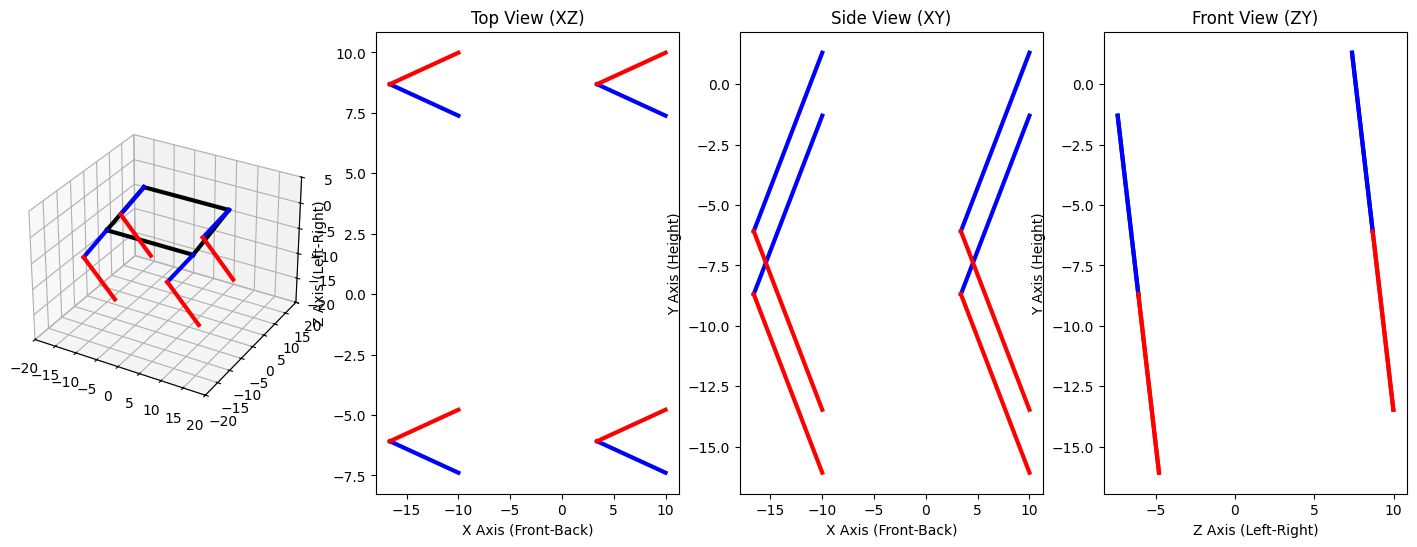

In [6]:
R = transforms3d.euler.euler2mat(math.radians(10),0,0)
gyro_shoulder_positions = R @ shoulder_positions
gyro_body_lines = [
    (gyro_shoulder_positions[:, 0], gyro_shoulder_positions[:, 1]),
    (gyro_shoulder_positions[:, 2], gyro_shoulder_positions[:, 3]),
    (gyro_shoulder_positions[:, 0], gyro_shoulder_positions[:, 2]),
    (gyro_shoulder_positions[:, 1], gyro_shoulder_positions[:, 3]),
]

gyro_knee_positions = R @ knee_positions
gyro_foot_positions = R @ foot_positions

fig = plt.figure(figsize=(18, 6))
gyro_ax3d = fig.add_subplot(141, projection='3d')
gyro_ax3d.set_xlim(-20,20)
gyro_ax3d.xaxis.set_major_locator(MultipleLocator(5))
gyro_ax3d.set_ylim(-20,20)
gyro_ax3d.yaxis.set_major_locator(MultipleLocator(5))
gyro_ax3d.set_zlim(-20,5)

# XZ 平面 (正視圖)
gyro_ax_xz = fig.add_subplot(142)
gyro_ax_xz.set_title("Top View (XZ)")
gyro_ax_xz.set_xlabel("X Axis (Front-Back)")
gyro_ax_xz.set_ylabel("Z Axis (Left-Right)")

# XY 平面 (側視圖)
gyro_ax_xy = fig.add_subplot(143)
gyro_ax_xy.set_title("Side View (XY)")
gyro_ax_xy.set_xlabel("X Axis (Front-Back)")
gyro_ax_xy.set_ylabel("Y Axis (Height)")

# ZY 平面 (俯視圖)
gyro_ax_zy = fig.add_subplot(144)
gyro_ax_zy.set_title("Front View (ZY)")
gyro_ax_zy.set_xlabel("Z Axis (Left-Right)")
gyro_ax_zy.set_ylabel("Y Axis (Height)")

for line in gyro_body_lines:
    gyro_ax3d.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], [line[0][2], line[1][2]], 'k-', lw=3)

for i in range(4):
    gyro_ax3d.plot(
        [gyro_shoulder_positions[0, i], gyro_knee_positions[0, i]],
        [gyro_shoulder_positions[1, i], gyro_knee_positions[1, i]],
        [gyro_shoulder_positions[2, i], gyro_knee_positions[2, i]],
        'b-', lw=3)  # 大腿

    gyro_ax3d.plot(
        [gyro_knee_positions[0, i], gyro_foot_positions[0, i]],
        [gyro_knee_positions[1, i], gyro_foot_positions[1, i]],
        [gyro_knee_positions[2, i], gyro_foot_positions[2, i]],
        'r-', lw=3)  # 小腿
    
# 繪製 XZ 平面
for i in range(4):
    gyro_ax_xz.plot([gyro_shoulder_positions[0, i], gyro_knee_positions[0, i]], [gyro_shoulder_positions[1, i], gyro_knee_positions[1, i]], 'b-', lw=3)  # 大腿
    gyro_ax_xz.plot([gyro_knee_positions[0, i], gyro_foot_positions[0, i]], [gyro_knee_positions[1, i], gyro_foot_positions[1, i]], 'r-', lw=3)  # 小腿

# 繪製 XY 平面
for i in range(4):
    gyro_ax_xy.plot([gyro_shoulder_positions[0, i], gyro_knee_positions[0, i]], [gyro_shoulder_positions[2, i], gyro_knee_positions[2, i]], 'b-', lw=3)  # 大腿
    gyro_ax_xy.plot([gyro_knee_positions[0, i], gyro_foot_positions[0, i]], [gyro_knee_positions[2, i], gyro_foot_positions[2, i]], 'r-', lw=3)  # 小腿

# 繪製 ZY 平面
for i in range(4):
    gyro_ax_zy.plot([gyro_shoulder_positions[1, i], gyro_knee_positions[1, i]], [gyro_shoulder_positions[2, i], gyro_knee_positions[2, i]], 'b-', lw=3)  # 大腿
    gyro_ax_zy.plot([gyro_knee_positions[1, i], gyro_foot_positions[1, i]], [gyro_knee_positions[2, i], gyro_foot_positions[2, i]], 'r-', lw=3)  # 小腿

plt.show()